In [1]:
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl, seaborn.apionly as sns
import pcmdpy as ppy
from time import time
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

GPU acceleration enabled


In [2]:
ppy.gpu_utils.initialize_gpu(n=0)
f = ppy.instrument.m31_filters()
iso_model = ppy.isochrones.Isochrone_Model(f)
driv = ppy.driver.Driver(iso_model, gpu=True)

using given n: 0
Starting SourceModule Code
Past the SourceModule code
CUDAC Available


In [42]:
N_im = 2048
gal = ppy.galaxy.DefaultTau.get_model(np.array([-.2, -1., 2., 5.]))

In [54]:
N_ims = [256, 512, 1024, 2048]
d_factors = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]

In [50]:
pcmds = {}
times = {}
for N_im in tqdm(N_ims):
    for d in tqdm(d_factors):
        start = time()
        pcmds[(N_im, d)], _ = driv.simulate(gal, N_im, downsample=d)
        times[(N_im, d)] = time() - start

In [51]:
driv.initialize_data(pcmds[256, 1])

In [52]:
mags, colors = np.concatenate([pcmd for pcmd in pcmds.values()], axis=-1)

In [53]:
bins = [np.linspace(colors.min(), colors.max(), 100), np.linspace(mags.min(), mags.max(), 100)]

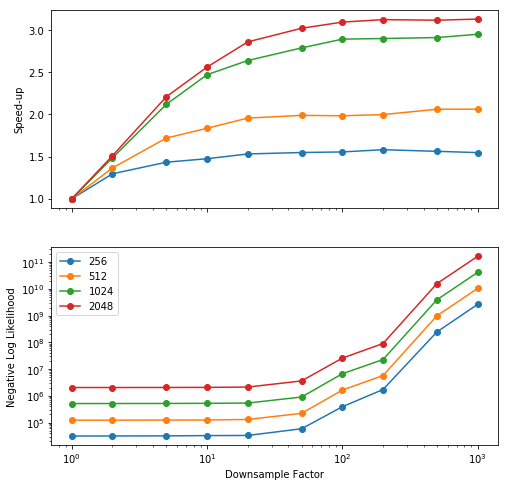

In [74]:
fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(8, 8))
for N in N_ims:
    t = [times[(N,1)] / times[(N, d)] for d in d_factors]
    driv.initialize_data(pcmds[(N,1)])
    ll = [driv.loglike(pcmds[(N, d)]) for d in d_factors]
    axes[0].plot(d_factors, t, ls='-', marker='o', label=N)
    axes[1].plot(d_factors, np.abs(ll), ls='-', marker='o', label=N)
axes[0].set_xscale('log')
axes[1].set_yscale('log')
axes[1].legend(loc=0)
axes[0].set_ylabel('Speed-up'), axes[1].set_ylabel('Negative Log Likelihood')
axes[1].set_xlabel('Downsample Factor')
plt.savefig('figures/downsample_results.pdf')

In [58]:
ssp = ppy.galaxy.DefaultSSP.get_model(np.array([0., -2., 1., 10.]))

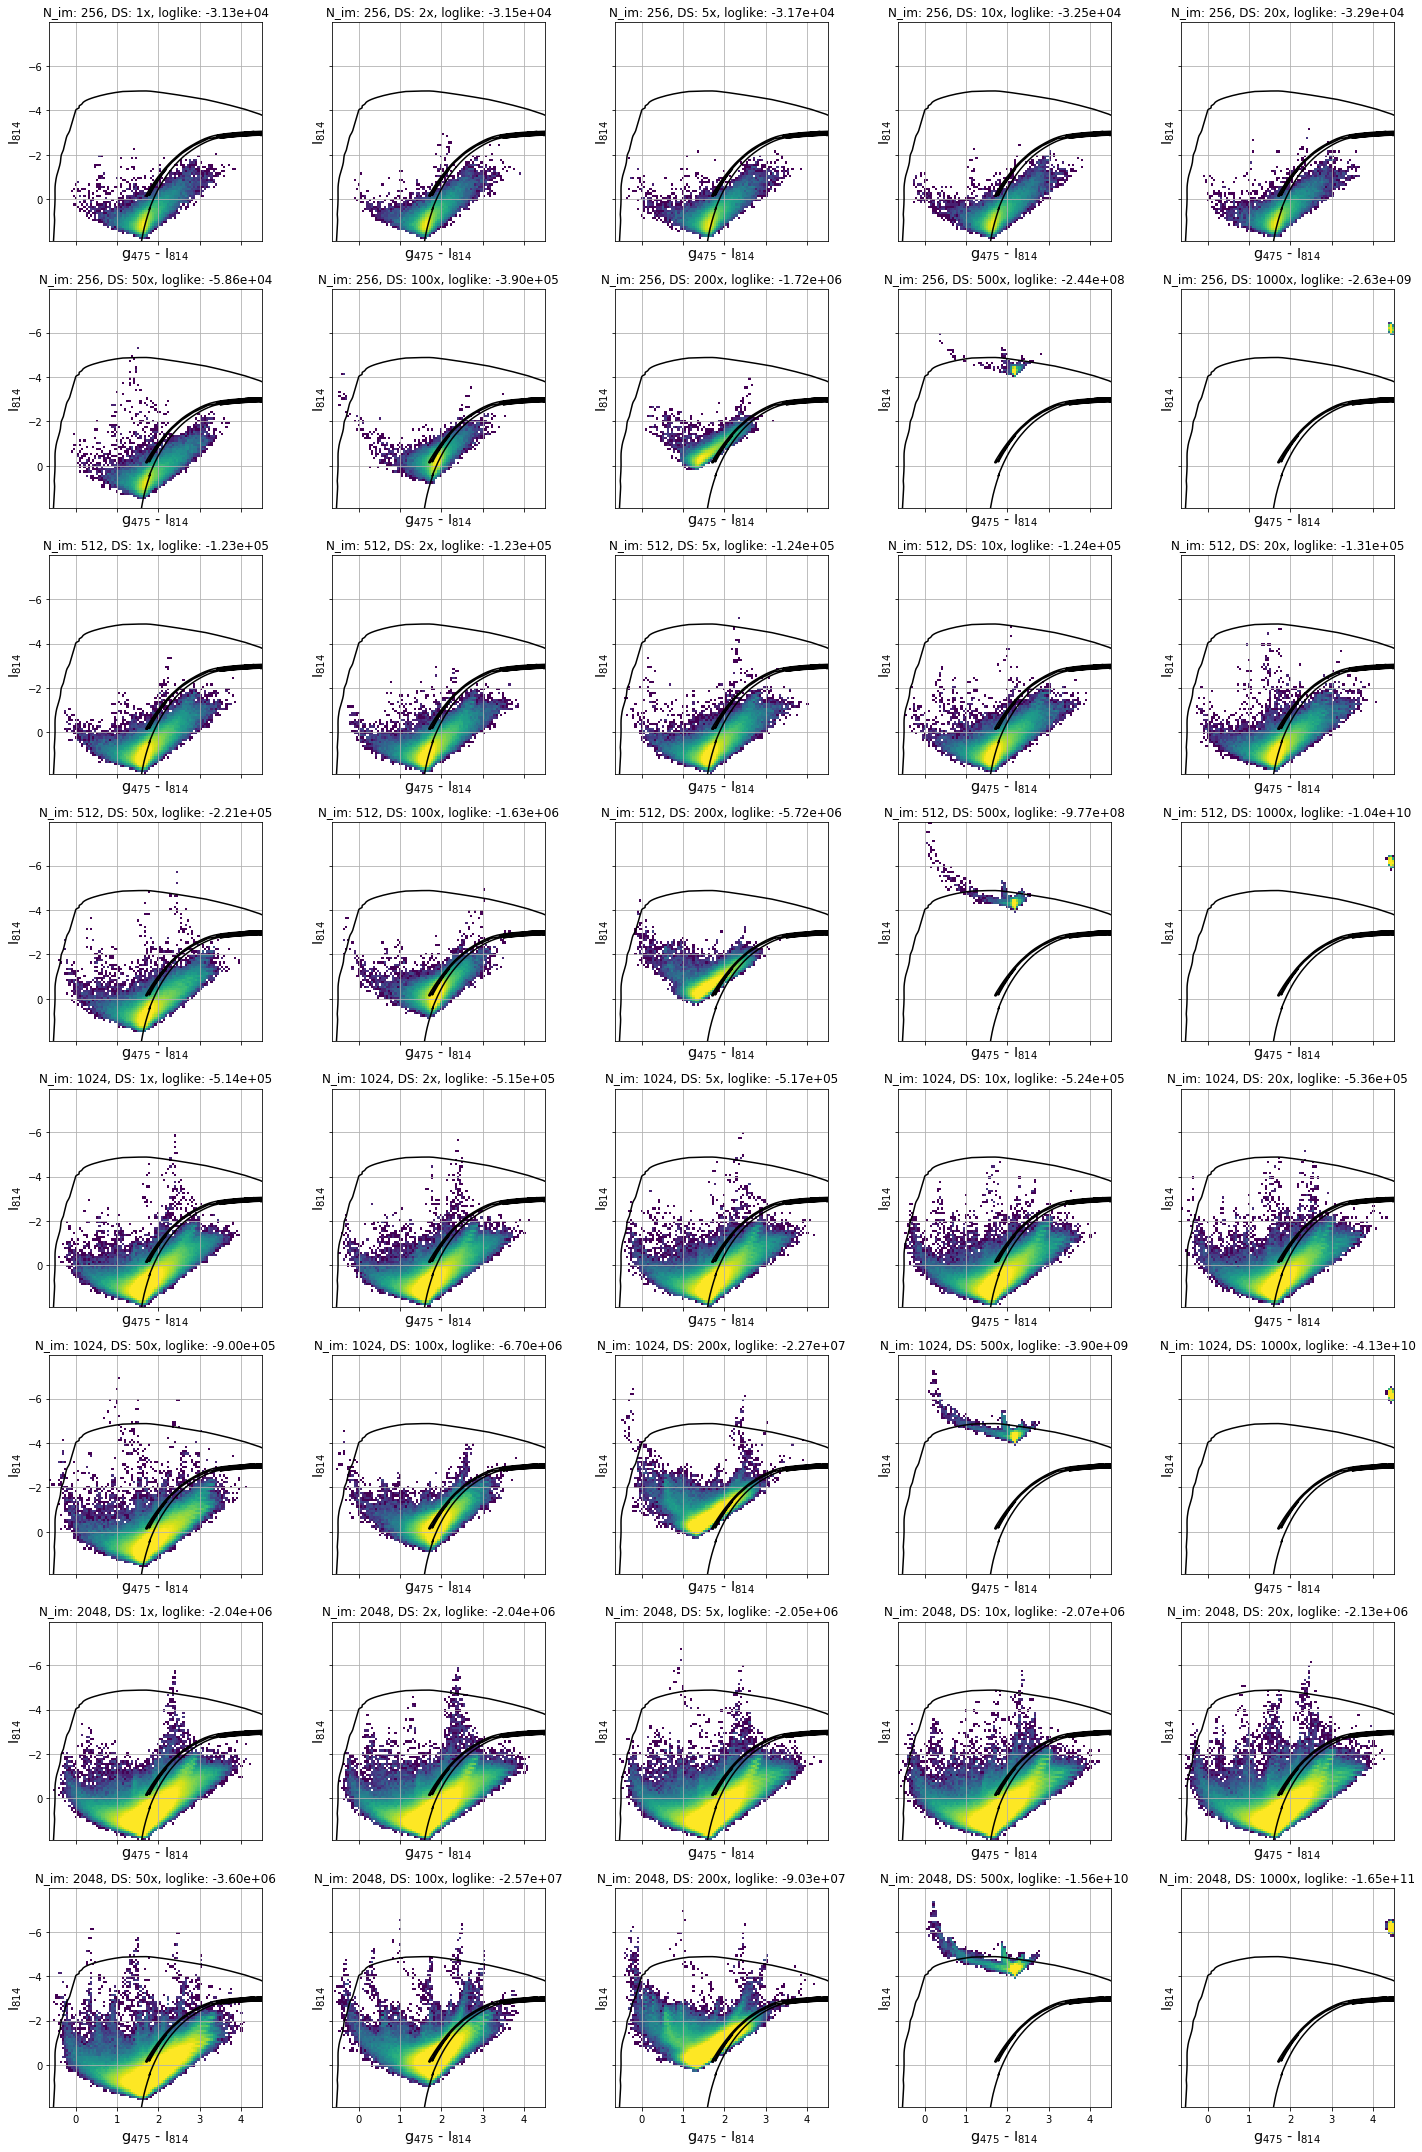

In [68]:
fig, axes = plt.subplots(ncols=5, nrows=8, figsize=(20, 30), sharex=True, sharey=True)
axes = axes.flatten()
n = mpl.colors.LogNorm()
for i, N in enumerate(N_ims):
    driv.initialize_data(pcmds[(N, 1)])
    for j, d in enumerate(d_factors):
        k = j + 10*i
        plt.subplot(axes[k])
        mags, colors = pcmds[(N, d)]
        plt.hist2d(colors, mags, bins=bins, norm=n)
        loglike = driv.loglike(pcmds[(N, d)])
        axes[k].set_title('N_im: {:d}, DS: {:d}x, loglike: {:.2e}'.format(N, d, loglike))
        axes[k].grid(True)
        iso_model.plot_isochrone(ssp, axes=axes[k])
plt.tight_layout()
plt.savefig('figures/downsample_hess.pdf')